In [30]:
import math
import numpy as np
import plotly.figure_factory as ff
import rasterio
import string 
import pandas as pd

from rasterio.plot import show
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm, multivariate_normal
from scipy.ndimage import gaussian_filter


In [31]:
cmap = "viridis"
pi=math.pi

In [32]:
with rasterio.open('./img/cropped/red.tif') as src:
    red=src.read(1)
with rasterio.open('./img/cropped/nir.tif') as src:
    nir = src.read(1)

with rasterio.open('./img/2. IMG_700101_000458_0092_NIR.TIF') as src:
    nir_field = src.read(1)

with rasterio.open('img/3. IMG_700101_000458_0092_RED.TIF') as src:
    red_field = src.read(1)


In [33]:
red = red/65535.0
nir = nir/65535.0
red_field = red_field/65535.0
nir_field = nir_field/65535.0

ndvi =(nir.astype(float)-red.astype(float)/(nir+red))
ndvi_field =(nir_field.astype(float)-red_field.astype(float)/(nir_field+red_field))

In [34]:
def calculate_ndvi(red, nir):
    ndvi = (nir - red) / (nir + red)
    return (ndvi)

In [35]:
def kurt_factor(ndvi):
    #return 1 + 1 * ndvi
    kurt_factor = np.mean((ndvi - np.mean(ndvi)) ** 4) / (np.var(ndvi) ** 2)
    return kurt_factor


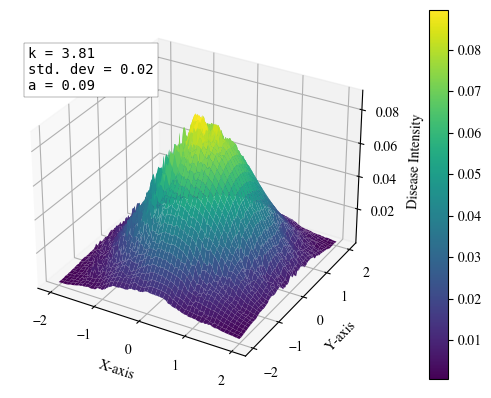

In [36]:
# Calculate the NDVI values
ndvi = (nir - red) / (nir + red)

def create_one_graph(ndvi):
    # Define the parameters for the Gaussian bell function
    x = 0  # center point
    y = 0  # center point
    sigma_xy = 1  # spread in the xy plane
    sigma_z = 1  # spread in the z direction
    Qm = 1  # maximum value of the bell function

    # Create a meshgrid for the x, y, and NDVI values
    xf, yf = np.meshgrid(np.linspace(-2, 2, ndvi.shape[1]), np.linspace(-2, 2, ndvi.shape[0]))
    ndvif = np.meshgrid(np.linspace(-1, 1, ndvi.shape[1]), np.linspace(-1, 1, ndvi.shape[0]))[0]

    # Create the 3D Gaussian bell function based on the NDVI values
    f = (Qm * np.exp(-(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)) / ((2 * (np.pi ** (3/2))) * sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2)))

    # Calculate the kurtosis, standard deviation, and amplitude of the plot
    kurtosis = kurt_factor(ndvi)
    std = np.std(f)
    amplitude = np.max(f)

    # Plot the 3D Gaussian bell function
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array(f)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
    ax.plot_surface(xf, yf, f, cmap=cmap)
    textstr = '\n'.join((
        'k = {:.2f}'.format(kurtosis),
        'std. dev = {:.2f}'.format(std),
        'a = {:.2f}'.format(amplitude)))
    ax.text2D(0.05, 0.90, s=textstr, family='monospace', transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', linewidth=0.2, boxstyle='square'))
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Disease Intensity')
    plt.rcParams['font.family'] = 'Times'
    plt.show()

create_one_graph(ndvi)






Grafica de multiples campanas

In [37]:
# Create a meshgrid for the x, y, and NDVI values
xf, yf = np.meshgrid(np.linspace(-10, 10, ndvi_field.shape[1]), np.linspace(-10, 10, ndvi_field.shape[0]))
ndvif = np.meshgrid(np.linspace(-1, 1, ndvi_field.shape[1]), np.linspace(-1, 1, ndvi_field.shape[0]))[0]

def calculate_ndvi(red, nir):
    #Calculate the NDVI values
    ndvi = (nir - red) / (nir + red)
    return(ndvi)

def gaussian_with_image(Qm, x, y, sigma_xy, sigma_z, ndvi, ndvif, xf, yf):
    # Create the 3D Gaussian bell function based on the NDVI values
    #f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))
   
   #Proofs
    f = (Qm * np.exp( -(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)) / ((2 * np.pi ** (3/2))* sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) ))
    #f = (Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2)- (yf - y) ** 2 / (2 * sigma_xy ** 2)) + np.exp(- (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)))
   
    #threshold = 1e-2
    #f[f < threshold] = np.nan
    return f

def plot_gaussian(f, xf, yf):
    # Plot the 3D Gaussian bell function
    ax.plot_surface(xf, yf, f, cmap='binary')


Recorte manual de la imagen 

In [38]:
def image_cropper(ndvi_field,x1,y1,x2,y2):
    """
    This function is used to crop the image
    """
    ndvi_mask = np.zeros(ndvi_field.shape, dtype=np.uint8)
    ndvi_mask[y1:y2, x1:x2] = 1

    # Apply the mask to the NDVI image
    ndvi_field = np.array(ndvi_field) * ndvi_mask

    # Create a RGB image from the NDVI image
    return ndvi_field
    # Convert the Numpy array to a PIL Image object
    #img = Image.fromarray(rgb_field)

In [39]:
ndvi1 = image_cropper(ndvi_field, 420, 220, 650, 450)
ndvi2 = image_cropper(ndvi_field, 500, 420, 730, 650)
ndvi3 = image_cropper(ndvi_field, 520, 600, 750, 830)

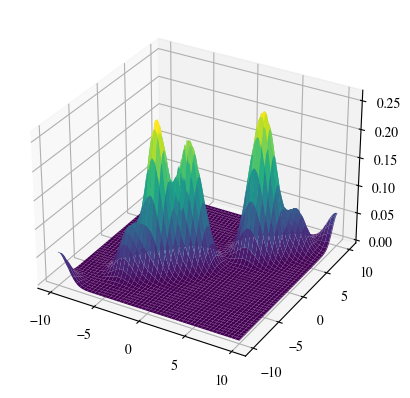

In [40]:
cmap2 = 'viridis'

f = gaussian_with_image(1, 0, 0, 1,1, ndvi1, ndvif, xf, yf)
f2 = gaussian_with_image(2, 4, 4, 1,1,ndvi2,ndvif,xf,yf)
f3 = gaussian_with_image(3, -3, -3, 1,1,ndvi3,ndvif,xf,yf)
f4 = gaussian_with_image(2, 5, 5, 1,1,ndvi1,ndvif,xf,yf)
f5 = gaussian_with_image(1, 7, 7, 1,1,ndvi1,ndvif,xf,yf)
f6= gaussian_with_image(1,10,10, 1,1,ndvi1,ndvif,xf,yf)
f7 = gaussian_with_image(2, -1, -1, 1,1,ndvi1,ndvif,xf,yf)
f8 = gaussian_with_image(1, -10, -10, 1,1,ndvi1,ndvif,xf,yf)
f9= gaussian_with_image(1,-5,-5, 1,1,ndvi1,ndvif,xf,yf)

ff = f+f2+f3+f4+f5+f6+f7+f8+f9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xf, yf, ff, cmap=cmap2, alpha=1)

plt.show()